# Pymaceuticals Inc.
---

### Analysis

- Based on the appearance of the box plots of average tumor sizes, including placebo, Capomulin and Ramicane are helpful for reducing tumor volume. Infubinol and Ceftamin are not noticeably more effective than placebo. Note this is based on a simplistic view of the data, not a rigorous statistical analysis.

- Some mice stopped getting entries earlier than others. Including them makes the "average tumor volume" measure less useful, and the reason for their early ending might be important. If the mice died, for instance, that would be an important health outcome.

- Before making any decisions, I suggest looking at the overall trajectory of the tumor size, not just the average across all samples. I also suggest at least a cursory look at metastatis sites and whether the mice are actually still alive.

 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Important column names
COL_MOUSE_ID = "Mouse ID"
COL_MOUSE_SEX = "Sex"
COL_MOUSE_AGE = "Age_months"
COL_MOUSE_MASS = "Weight (g)"
COL_DRUG = "Drug Regimen"
COL_TIME = "Timepoint"
COL_TUMOR_VOL = "Tumor Volume (mm3)"
COL_METS = "Metastatic Sites"
COL_FINAL_TUMOR_VOL = "Final Tumor Volume (mm3)"


In [2]:
# This function isn't required for the challenge, I just use it to get a feel for the data in a dataframe
def print_df_overview(df, title):        
    print(f"{title} DF Head:")
    print(df.head())
    print("----------------------------------")
    print(f"{title} DF Columns:")
    print(df.columns)
    print("----------------------------------")
    print(f"{title} DF dtypes:")
    print(df.dtypes)
    
    for col in df.columns:
        print("----------------------------------")
        print(f"{title} DF column value counts:")

        ABRIDGED_ROWS = 16
        counts = df[col].value_counts()
        if counts.size < 2*ABRIDGED_ROWS:
            # Print the counts all together
            print(col, "counts:")    
            print(counts)
        else:
            # Print top and bottom counts
            print(col, "top counts:")
            print(counts.iloc[0:ABRIDGED_ROWS])
            print(col, "bottom counts:")
            print(counts.iloc[-ABRIDGED_ROWS:])

In [3]:
# Read the mouse data and the study results
mice_df = pd.read_csv(mouse_metadata_path)
studies_df = pd.read_csv(study_results_path)

# For troubleshooting:
#print_df_overview(mice_df, "Mice")
#print_df_overview(studies_df, "Studies")

# Combine the data into a single DataFrame
combined_df = studies_df.merge(mice_df)

# Display the data table for preview
#print_df_overview(combined_df, "Combined")
combined_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,f932,0,45.000000,0,Ketapril,Male,15,29
2,g107,0,45.000000,0,Ketapril,Female,2,29
3,a457,0,45.000000,0,Ketapril,Female,11,30
4,c819,0,45.000000,0,Ketapril,Male,21,25
...,...,...,...,...,...,...,...,...
1888,r944,45,41.581521,2,Capomulin,Male,12,25
1889,u364,45,31.023923,3,Capomulin,Male,18,17
1890,p438,45,61.433892,1,Ceftamin,Female,11,26
1891,x773,45,58.634971,4,Placebo,Female,21,30


In [4]:
# Checking the number of mice.
combined_df[COL_MOUSE_ID].nunique()

249

In [5]:
# Our data should be uniquely identified by Mouse ID and Timepoint
# Get the duplicate mice by ID number that shows up for Mouse ID and Timepoint.
# This returns the REDUNDANT entries, not all entries for duplicated mice:
redundant_df = combined_df.loc[combined_df.duplicated(subset = [COL_MOUSE_ID, COL_TIME]) ]
redundant_IDs = redundant_df[COL_MOUSE_ID].unique()
print(f"Mice with redundant study entries: {redundant_IDs}")

Mice with redundant study entries: ['g989']


In [6]:
# Optional: Get all the data for the duplicate mouse ID.
# This code assumes exactly one duplicated mouse, to more easily take advantageof Notebook's pretty formatting:
combined_df.loc[combined_df[COL_MOUSE_ID] == redundant_IDs[0]]

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
107,g989,0,45.000000,0,Propriva,Female,21,26
137,g989,0,45.000000,0,Propriva,Female,21,26
329,g989,5,48.786801,0,Propriva,Female,21,26
360,g989,5,47.570392,0,Propriva,Female,21,26
620,g989,10,51.745156,0,Propriva,Female,21,26
681,g989,10,49.880528,0,Propriva,Female,21,26
815,g989,15,51.325852,1,Propriva,Female,21,26
869,g989,15,53.442020,0,Propriva,Female,21,26
950,g989,20,55.326122,1,Propriva,Female,21,26
1111,g989,20,54.657650,1,Propriva,Female,21,26


In [7]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
#
# Dropping the mouse by its ID doesn't actually seem like the right thing to do.
# There is no "duplicated mouse", there is a mouse with duplicated study entries. We should just remove the
# duplicated study entries, not everything for the mouse.
#
# But to reconcile my results with what's expected, I'll remove the whole mouse:
clean_df = combined_df.copy()
for id in redundant_IDs:
    clean_df = clean_df.loc[clean_df[COL_MOUSE_ID] != id]

redundant_df = clean_df.loc[clean_df.duplicated(subset = [COL_MOUSE_ID, COL_TIME]) ]
redundant_IDs = redundant_df[COL_MOUSE_ID].unique()
print(f"Mice with redundant study entries (hopefully none now): {redundant_IDs}")

clean_df

Mice with redundant study entries (hopefully none now): []


,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,f932,0,45.000000,0,Ketapril,Male,15,29
2,g107,0,45.000000,0,Ketapril,Female,2,29
3,a457,0,45.000000,0,Ketapril,Female,11,30
4,c819,0,45.000000,0,Ketapril,Male,21,25
...,...,...,...,...,...,...,...,...
1888,r944,45,41.581521,2,Capomulin,Male,12,25
1889,u364,45,31.023923,3,Capomulin,Male,18,17
1890,p438,45,61.433892,1,Ceftamin,Female,11,26
1891,x773,45,58.634971,4,Placebo,Female,21,30


In [8]:
# Checking the number of mice in the clean DataFrame.
print(f"Mice: {clean_df[COL_MOUSE_ID].nunique()}")

Mice: 248


## Summary Statistics

In [9]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen:
# mean, median, variance, standard deviation, and SEM of the tumor volume.
# Assemble the resulting series into a single summary DataFrame.

# Only you can prevent human error
COL_SUMM_TUMOR_VOL_MEAN = "Mean Tumor Volume"
COL_SUMM_TUMOR_VOL_MEDIAN = "Median Tumor Volume"
COL_SUMM_TUMOR_VOL_VAR = "Tumor Volume Variance"
COL_SUMM_TUMOR_VOL_SDEV = "Tumor Volume Std. Dev."
COL_SUMM_TUMOR_VOL_SEM = "Tumor Volume Std. Err."

grouped = clean_df.groupby(COL_DRUG)[COL_TUMOR_VOL]

summ_df = pd.DataFrame()
summ_df[COL_SUMM_TUMOR_VOL_MEAN] = grouped.mean()
summ_df[COL_SUMM_TUMOR_VOL_MEDIAN] = grouped.median()
summ_df[COL_SUMM_TUMOR_VOL_VAR] = grouped.var()
summ_df[COL_SUMM_TUMOR_VOL_SDEV] = grouped.std()
summ_df[COL_SUMM_TUMOR_VOL_SEM] = grouped.sem()
summ_df

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std. Dev.,Tumor Volume Std. Err.
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [10]:
# A more advanced method to generate a summary statistics table of mean, median, variance, standard deviation,
# and SEM of the tumor volume for each regimen (only one method is required in the solution)

# Using the aggregation method, produce the same summary statistics in a single line
clean_df.groupby(COL_DRUG).agg({COL_TUMOR_VOL: ["mean", "median", "var", "std", "sem"]})


Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

## Bar and Pie Charts

<Axes: xlabel='Drug Regimen', ylabel='# of Observed Mouse Timepoints'>

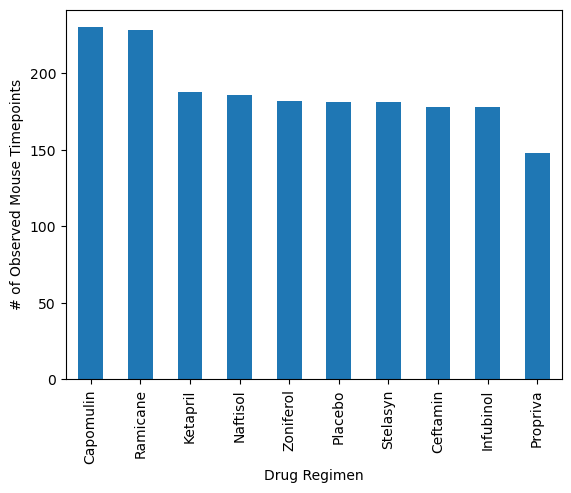

In [11]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using Pandas.
counts = clean_df.groupby(COL_DRUG)[COL_TIME].count().sort_values(ascending=False)
counts.plot(kind="bar", ylabel="# of Observed Mouse Timepoints")

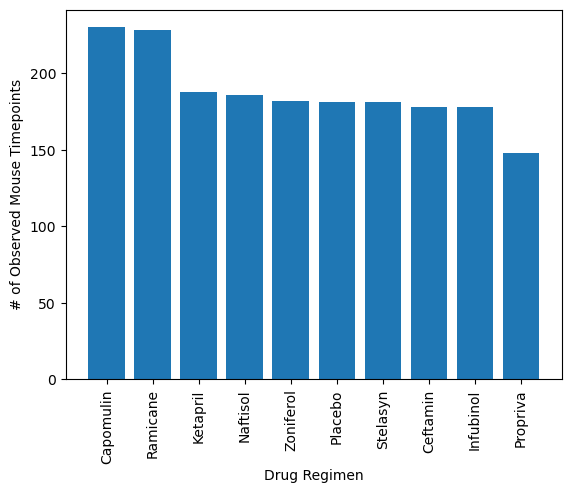

In [12]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using pyplot.
counts = clean_df.groupby(COL_DRUG)[COL_TIME].count().sort_values(ascending=False)
plt.bar(counts.index, counts)
plt.xlabel(counts.index.name)
plt.ylabel("# of Observed Mouse Timepoints")
plt.xticks(rotation=90)
plt.show()

<Axes: ylabel='count'>

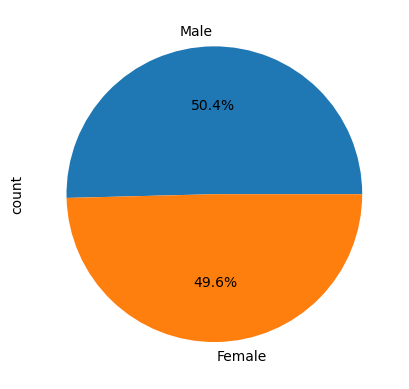

In [13]:
# Generate a pie chart, using Pandas, showing the distribution of unique female versus male mice used in the study

# Get the unique mice with their gender
# Every mouse has an entry for time==0, so use that:
counts = clean_df.loc[clean_df[COL_TIME] == 0].groupby(COL_MOUSE_SEX)[COL_TIME].count().sort_values(ascending=False)

# Make the pie chart
counts.plot(kind="pie", ylabel="count", autopct="%.1f%%")

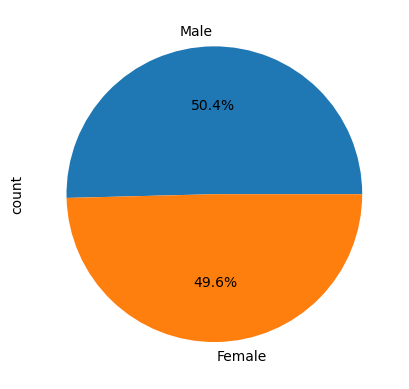

In [14]:
# Generate a pie chart, using pyplot, showing the distribution of unique female versus male mice used in the study

# Get the unique mice with their gender
# Every mouse has an entry for time==0, so use that:
counts = clean_df.loc[clean_df[COL_TIME] == 0].groupby(COL_MOUSE_SEX)[COL_TIME].count().sort_values(ascending=False)

# Make the pie chart
plt.pie(counts, labels=counts.index, autopct="%.1f%%")
plt.ylabel("count")
plt.show()

## Quartiles, Outliers and Boxplots

In [15]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
max_times = clean_df.groupby(COL_MOUSE_ID)[COL_TIME].max()

# This is simpler, since the samples are in chronological order:
final_tumor_sizes = clean_df.groupby(COL_MOUSE_ID)[COL_TUMOR_VOL].last()

# Merge this group df with the original DataFrame to get the tumor volume at the last timepoint
final_tumor_sizes_df = pd.DataFrame(final_tumor_sizes)
final_tumor_sizes_df = final_tumor_sizes_df.rename(columns={COL_TUMOR_VOL: COL_FINAL_TUMOR_VOL})
final_df = clean_df.merge(final_tumor_sizes_df, on=COL_MOUSE_ID)
final_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g),Final Tumor Volume (mm3)
0,b128,0,45.000000,0,Capomulin,Female,9,22,38.982878
1,f932,0,45.000000,0,Ketapril,Male,15,29,45.000000
2,g107,0,45.000000,0,Ketapril,Female,2,29,71.905117
3,a457,0,45.000000,0,Ketapril,Female,11,30,49.783419
4,c819,0,45.000000,0,Ketapril,Male,21,25,62.175705
...,...,...,...,...,...,...,...,...,...
1875,r944,45,41.581521,2,Capomulin,Male,12,25,41.581521
1876,u364,45,31.023923,3,Capomulin,Male,18,17,31.023923
1877,p438,45,61.433892,1,Ceftamin,Female,11,26,61.433892
1878,x773,45,58.634971,4,Placebo,Female,21,30,58.634971


In [16]:
# Put treatments into a list for for loop (and later for plot labels)
care_meds = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]

# Create empty list to fill with tumor vol data (for plotting)
# Acually a dictionary of empty lists:
final_volumes_by_med = {}
for med in care_meds:
    final_volumes_by_med[med] = []

# Calculate the IQR and quantitatively determine if there are any potential outliers.
for med in care_meds:

    # Locate the rows which contain mice on each drug and get the tumor volumes
    rows_this_med = final_df.loc[final_df[COL_DRUG] == med]
    final_volumes_this_med = rows_this_med.groupby(COL_MOUSE_ID)[COL_FINAL_TUMOR_VOL].last()

    # add subset
    final_volumes_by_med[med] = final_volumes_this_med.values.tolist()

    # Determine outliers using upper and lower bounds
    quartiles = final_volumes_this_med.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)

    outliers = final_volumes_this_med.loc[
            ~final_volumes_this_med.between(lower_bound, upper_bound)]
    print(f"{med} outliers:\n{outliers}\n")

# The output in the "starter" notebook suggests that Infubinol should have an outlier at 31 mm3, but that outlier is missing from the
# boxplot graph and I don't see any such data point in the provided dataset. So I believe the starter notebook's output is incorrect
# and that mine is correct.

Capomulin outliers:
Series([], Name: Final Tumor Volume (mm3), dtype: float64)

Ramicane outliers:
Series([], Name: Final Tumor Volume (mm3), dtype: float64)

Infubinol outliers:
Mouse ID
c326    36.321346
Name: Final Tumor Volume (mm3), dtype: float64

Ceftamin outliers:
Series([], Name: Final Tumor Volume (mm3), dtype: float64)



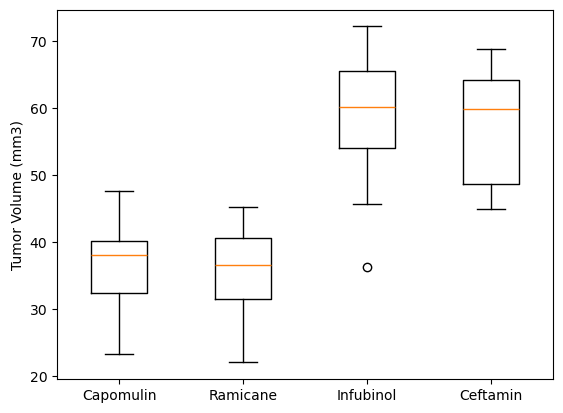

In [17]:
# Generate a box plot that shows the distribution of the tumor volume for each treatment group.
# Note the labels parameter is renamed in more recent MatPlotLib versions:
plt.boxplot(pd.DataFrame.from_dict(final_volumes_by_med), labels=care_meds)
plt.ylabel(COL_TUMOR_VOL)
plt.show()

## Line and Scatter Plots

<Axes: xlabel='Timepoint (days)', ylabel='Tumor Volume (mm3)'>

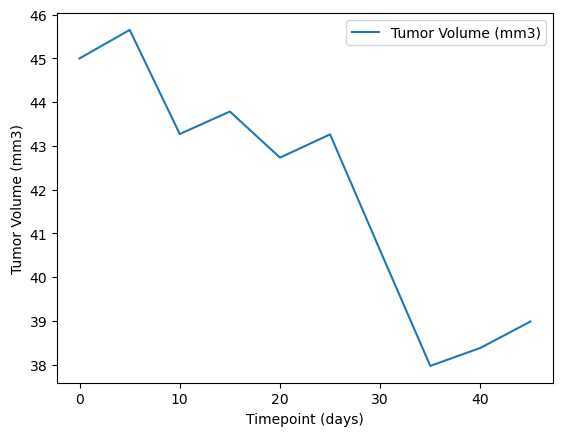

In [18]:
# Generate a line plot of tumor volume vs. time point for a single mouse treated with Capomulin
mouse_id = final_df.loc[final_df[COL_DRUG] == "Capomulin"][COL_MOUSE_ID].iloc[0]
mouse_volumes = final_df.loc[final_df[COL_MOUSE_ID] == mouse_id][[COL_TIME,COL_TUMOR_VOL]]
mouse_volumes = mouse_volumes.set_index(COL_TIME)
mouse_volumes.plot(ylabel=COL_TUMOR_VOL, xlabel="Timepoint (days)")

<Axes: xlabel='Weight (g)', ylabel='Average Tumor Volume (mm3)'>

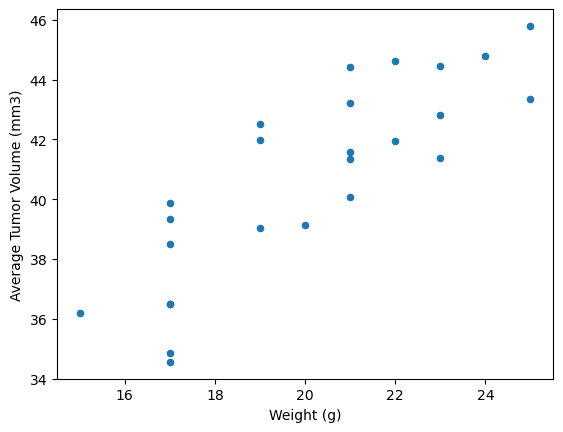

In [19]:
# Generate a scatter plot of mouse weight vs. the average observed tumor volume for the entire Capomulin regimen

# Get the right mice
capo_mice_df = final_df.loc[final_df[COL_DRUG] == "Capomulin"]

# Get the weight/mass and average tumor size for each of these mice
grouped = capo_mice_df.groupby(COL_MOUSE_ID)
masses = grouped[COL_MOUSE_MASS].first()
volumes = grouped[COL_TUMOR_VOL].mean()

# Do the plot
combined_df = pd.DataFrame.join(masses, volumes)
combined_df.plot.scatter(x=COL_MOUSE_MASS, y=COL_TUMOR_VOL, ylabel=f"Average {COL_TUMOR_VOL}")

## Correlation and Regression

The correlation between mouse weight and the average tumor volume is 0.84


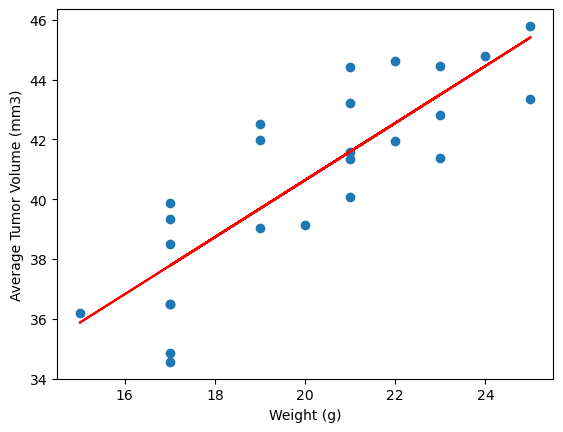

In [21]:
# Calculate the correlation coefficient and a linear regression model
# for mouse weight and average observed tumor volume for the entire Capomulin regimen
correlation = st.pearsonr(masses, volumes)
print(f"The correlation between mouse weight and the average tumor volume is {correlation.statistic:.2}")

# Set up a MatPlotLib sscatter plot
x_values = masses
y_values = volumes
plt.scatter(x_values,y_values)
plt.xlabel(x_values.name)
plt.ylabel(f"Average {y_values.name}")

# Add the linear regression line
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
plt.plot(x_values, regress_values, color="red")
plt.show()